# PHYS-GA2059 - Statistics and Data Science for Physicists
# Student: Gehan Ranepura
## Problem Set #3 - Problems 2, 4, 10 from
Hogg et al. (2017). Data analysis recipes: Using Markov Chain Monte Carlo
https://doi.org/10.48550/arXiv.1710.06068

In [1]:
import sys
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import pylab as pyplt
import scipy as sci

from numpy.linalg import inv
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import patches
from pylab import cm
from scipy import linalg
from scipy import stats
from scipy.optimize import minimize

## Problem 2: 
In your scientific programming language of choice, write a very simple MH MCMC sampler. 

Sample in a single parameter $x$ and give the sampler as its density function $p(x)$ a Gaussian density with mean 2 and variance 2. (Note that variance is the square of the standard deviation.) 

- Give the sampler a proposal distribution $q(x_0 | x)$ a Gaussian pdf $x'$ for $x = 0$ with mean $x$ and variance 1. Initialize the sampler with $x = 0$ and run the sampler for more than $10^4$ steps. 
- Plot the results as a histogram, with the true density over-plotted sensibly. The resulting plot should look something like Figure 1.

![alt text](Figure1.png "Title")

## Solution
### Definition of a Gaussian Function

Gaussian functions are often used to represent the probability density function of a normally distributed random variable $(x)$ with expected value $(μ)$ and variance $(\sigma^2)$. 
https://en.wikipedia.org/wiki/Gaussian_function

$$ N(x) = \frac{1}{ \sqrt{2 \pi \sigma^2} } \exp \left( - \frac{1}{2} \frac{ (x-\mu)^2 }{\sigma^2} \right) $$

Therefore, a gaussian distribution with $\mu = 2$ and $\sigma^2 = 2$ is: 
$$ N(x) = \frac{1}{ \sqrt{2 \pi \sigma^2} } \exp \left( - \frac{1}{2} \frac{ (x-2)^2 }{2} \right)$$

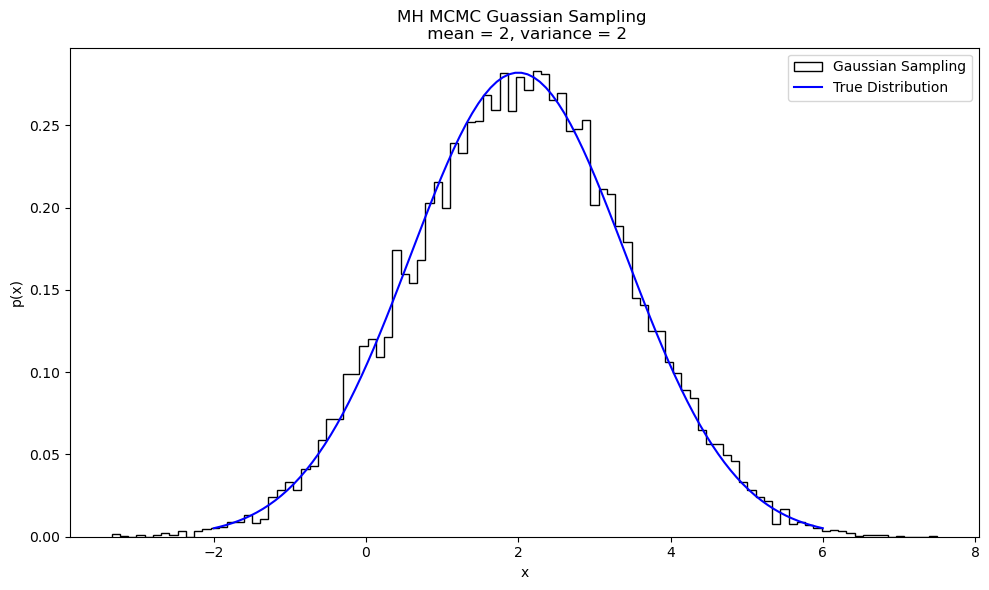

In [2]:
# Define a Guassian Function, given inputs are x, mean and sigma
def gaussian(x, mu, sigma):
    norm = 1/np.sqrt(2*np.pi*sigma**2)
    return norm * np.exp(-1/2 * (x-mu)**2/sigma**2)

x = 0                     # Initial Sample Value
xlist = [x]               # Accepted Values From MCMC Sampling
N = 20000                 # Number of Samplings
while len(xlist) < N:
    x_prime = np.random.normal(loc=x)
    r = np.random.uniform()
    #r = 0.5
    
    # Find xi, the ratio between proposal guassian with initialized Guassian starting at 0
    g  = gaussian(x_prime, 2, np.sqrt(2))     # Guassian Function for a randomized x value
    g0 = gaussian(x, 2, np.sqrt(2))           # Guassian Function for an initial x value 
    xi = g/g0
    
    # Perform MCMC and if accepted, new inital value is set to x for next sampling iteration
    if xi > r: # accept                      
        x = x_prime                           
    xlist.append(x) 

plt.figure(figsize=(10,6))
plt.hist(xlist, bins = 100, density = True, histtype = u'step', color='k', label='Gaussian Sampling')
x = np.linspace(-2, 6, 100)
plt.plot(x, gaussian(x, 2, np.sqrt(2)), 'b', label='True Distribution')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.title('MH MCMC Guassian Sampling \n mean = 2, variance = 2')
plt.tight_layout()

## Problem 4: 
Re-do Problem 2 but now with an input density that is a function of two variables (x, y). 
For the density function use two different functions. 

(a) The first density function is a covariant two-dimensional Gaussian density with variance tensor

$$ V = \begin{bmatrix} 2.0 & 1.2 \\ 1.2 & 2.0 \end{bmatrix}$$

(b) The second density function is a rectangular top-hat function that is uniform on the joint constraint $ 3 < x < 7 $ and $ 1 < y < 9 $ and zero everywhere else. For the proposal distribution $ q(x', y'| x, y) $ a two-dimensional Gaussian density with mean at $[x, y]$ and variance tensor set to the two-dimensional identity matrix. 
- Plot the two one-dimensional histograms and also a two-dimensional scatter plot for each sampling.
- Figure 3 shows the expected results for the Gaussian. Make a similar plot for the tophat.

![alt text](Figure2.png "Title")

## Solution (4a)
### Definition of a Multi-Variable Gaussian Function

In the 2-dimensional case, bivariate case 
https://en.wikipedia.org/wiki/Multivariate_normal_distribution

$$ N(x_1,x_2) = \frac{1}{ 2 \pi \sigma_1 \sigma_2 \sqrt{1 - \rho^2} }  \exp \left( -\frac{\alpha}{2 (1-\rho^2)} \right) $$

where,

$$ \alpha = \left( \frac{x_1 - \mu_1}{\sigma_1} \right)^2 
- 2\rho \left( \frac{x_1 - \mu_1}{\sigma_1} \right) \left( \frac{x_2 - \mu_2}{\sigma_2} \right)
+ \left( \frac{x_2 - \mu_2}{\sigma_2} \right)^2 $$

and $\rho$ is the Pearson's correlation coefficent

$$ \rho_{x_1,x_2} = \frac{cov(x_1,x_2)}{\sigma_1 \sigma_2} = \frac{\sigma_{1,2}}{\sigma_1 \sigma_2}$$

Here, the covariance matrix is:

$$ \Sigma = 
\begin{bmatrix} 
\sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_2 \sigma_1 & \sigma_2^2
\end{bmatrix} =
\begin{bmatrix} 
2 & 1.2  \\ 1.2 & 2
\end{bmatrix}
$$

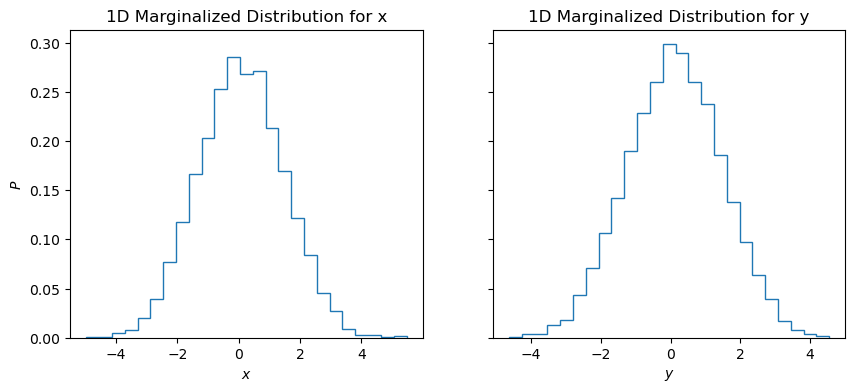

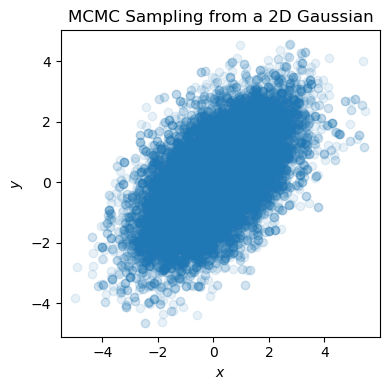

In [3]:
# Define a Bivariate Guassian Function, given inputs are x, mean and sigma
def biv_gaussian(x1, x2, mu1, mu2, sigma1, sigma2, rho):
    alpha = (x1-mu1)**2/sigma1**2 + (x2-mu2)**2/sigma2**2 - (2*rho*(x1-mu1)*(x2-mu2))/(sigma1*sigma2) 
    norm = 1/(2*np.pi*sigma1*sigma2*np.sqrt(1-rho**2))
    return norm*np.exp(-alpha/(2*(1-rho**2)))

mu1, mu2, sigma1, sigma2 = 0, 0, np.sqrt(2), np.sqrt(2)
rho = 1.2/(sigma1*sigma2)

x = 0           # Initial Sample x Value
y = 0           # Initial Sample y Value
xlist = [x]     # Accepted x Values From MCMC Sampling
ylist = [y]     # Accepted y Values From MCMC Sampling
N = 20000       # Number of Samplings
while len(xlist) & len(ylist) < N:
    x_prime = np.random.normal(loc=x)
    y_prime = np.random.normal(loc=y)
    #r = 0.5
    
    # Find xi, the ratio between proposal guassian with initialized Guassian starting at 0
    r = np.random.uniform()
    g  = biv_gaussian(x_prime, y_prime, mu1, mu2, sigma1, sigma2, rho)  # Guassian Function for a randomized x & y values
    g0 = biv_gaussian(x, y, mu1, mu2, sigma1, sigma2, rho)              # Guassian Function for an initial x & y values
    xi = g/g0
   
    # Perform MCMC and if accepted, new inital values is set to x' & y' for next sampling iteration
    if xi > r: #accept                                                  
        x = x_prime
        y = y_prime
    xlist.append(x)
    ylist.append(y)
    
fig,ax = plt.subplots(1,2, sharey = True, figsize = (10,4))
ax[0].hist(xlist, bins = 25, density = True, histtype=u'step')
ax[1].hist(ylist, bins = 25, density = True, histtype=u'step')
ax[0].set_title('1D Marginalized Distribution for x')
ax[1].set_title('1D Marginalized Distribution for y')
ax[0].set_xlabel('$x$')
ax[1].set_xlabel('$y$')
_=ax[0].set_ylabel('$P$')

fig,ax = plt.subplots(figsize = (4,4))
ax.scatter(xlist, ylist, alpha = 0.1)
ax.set_title('MCMC Sampling from a 2D Gaussian')
ax.set_xlabel('$x$')
_=ax.set_ylabel('$y$')
plt.tight_layout()

## Solution (4b)

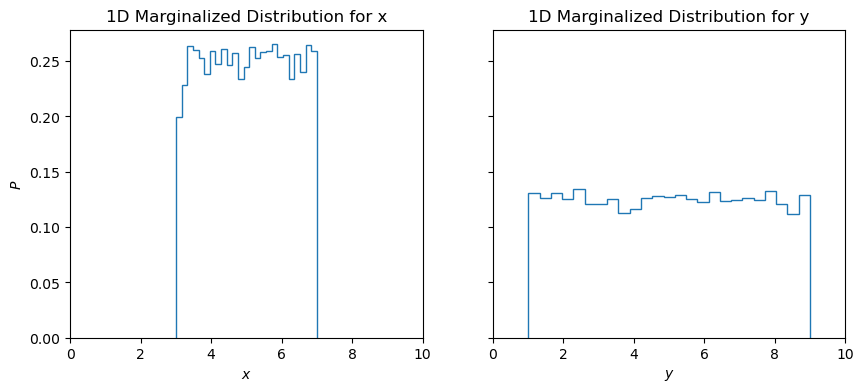

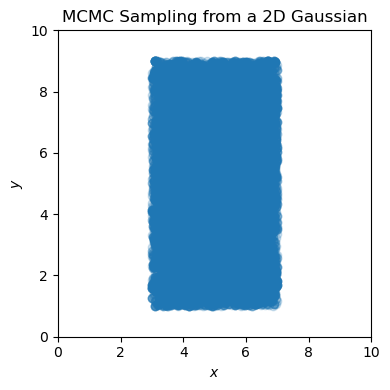

In [4]:
# Define a rectangular top-hat function, such that 3<x<7 & 1<y<9
def tophat(x, y):
    if ( (x<7) & (x>3) & (y>1) & (y<9) ):
        return 1
    else:
        return 0
    
x = 5           # Initial Sample x Value
y = 5           # Initial Sample y Value
xlist = [x]     # Accepted x Values From MCMC Sampling
ylist = [y]     # Accepted y Values From MCMC Sampling
N = 20000       # Number of Samplings
while len(xlist) & len(ylist) < N:
    x_prime = np.random.normal(loc=x)
    y_prime = np.random.normal(loc=y)
    r = np.random.uniform()
    #r = 0.5
    
    # Find xi, the ratio between proposal guassian with initialized Guassian starting at 5 
    # If x and y fall in the regional constraint
    if tophat(x,y) != 0:
        tophat_prime  = tophat(x_prime, y_prime)        # Guassian Function for a randomized x & y values
        tophat_inital = tophat(x, y)                    # Guassian Function for an initial x & y values
        xi = tophat_prime / tophat_inital
    # If x and y don't fall in the regional constraint, set xi = 1 which will always be neglected in MCMC
    else:
        xi = 1
        
    # Perform MCMC and if accepted, new inital values is set to x' & y' for next sampling iteration    
    if xi > r: #accept
        x = x_prime
        y = y_prime
    xlist.append(x)
    ylist.append(y)
    
fig,ax = plt.subplots(1,2,sharey = True, figsize = (10,4))
ax[0].hist(xlist, bins = 25, density = True, histtype=u'step')
ax[1].hist(ylist, bins = 25, density = True, histtype=u'step')
ax[0].set_title('1D Marginalized Distribution for x')
ax[1].set_title('1D Marginalized Distribution for y')
ax[0].set_xlabel('$x$')
ax[1].set_xlabel('$y$')
_=ax[0].set_ylabel('$P$')
ax[0].set_xlim([0,10])
ax[1].set_xlim([0,10])

fig,ax = plt.subplots(figsize = (4,4))
ax.scatter(xlist, ylist, alpha = 0.2)
ax.set_title('MCMC Sampling from a 2D Gaussian')
ax.set_xlabel('$x$')
_=ax.set_ylabel('$y$')
ax.set_xlim([0,10])
_=ax.set_ylim([0,10])
plt.tight_layout()

## Problem 10: 
Re-do Problem 2 but now look at convergence: Plot the x chain as a function of timestep. 
Also split the chain into four contiguous segments (the first, second, third, and fourth quarters of the chain). 

In each of these four, compute the empirical mean and empirical variance of x. What do you conclude about convergence from these heuristics?

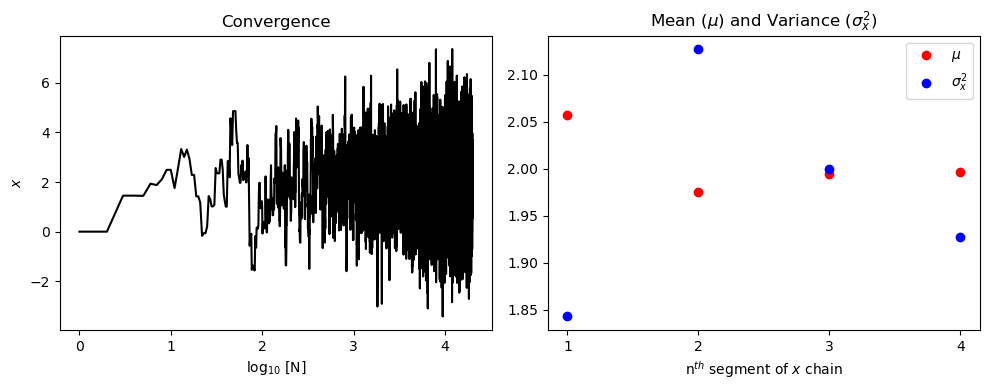

In [5]:
x = 0                     # Initial Sample Value
xlist = [x]               # Accepted Values From MCMC Sampling
N = 20000                 # Number of Samplings
while len(xlist) < N:
    x_prime = np.random.normal(loc=x)
    r = np.random.uniform()
    #r = 0.5
    
    # Find xi, the ratio between proposal guassian with initialized Guassian starting at 0
    g  = gaussian(x_prime, 2, np.sqrt(2))     # Guassian Function for a randomized x value
    g0 = gaussian(x, 2, np.sqrt(2))           # Guassian Function for an initial x value 
    xi = g/g0
    
    # Perform MCMC and if accepted, new inital value is set to x for next sampling iteration
    if xi > r: # accept                      
        x = x_prime                           
    xlist.append(x)

# Plot Convergence of x as a fucntion of sampling timestep
fig, ax = plt.subplots(1,2, figsize=(10,4))
Nlist = np.linspace(1,N,N)
ax[0].plot(np.log10(Nlist), xlist, 'k-')
ax[0].set_xlabel('log$_{10}$ [N]')
_=ax[0].set_ylabel('$x$')
_=ax[0].set_title('Convergence')

# Plot the Mean and Variance of the 1st, 2nd, 3rd and 4th quarter of the sampling chain
Q = int(N/4)
mean_x = [np.mean(xlist[0:Q]), np.mean(xlist[Q:2*Q]), np.mean(xlist[2*Q:3*Q]), np.mean(xlist[3*Q:N])]
var_x  = [np.std(xlist[0:Q])**2, np.std(xlist[Q:2*Q])**2, np.std(xlist[2*Q:3*Q])**2, np.std(xlist[3*Q:N])**2]

ax[1].scatter(np.arange(1,5), mean_x, marker = 'o',  c = 'red',  alpha = 1, label = '$ \mu $')
ax[1].scatter(np.arange(1,5), var_x,  marker = 'o',  c = 'blue', alpha = 1, label = '$\sigma_x^2$')
ax[1].set_xticks([1, 2, 3, 4])
ax[1].set_xlabel('n$^{th}$ segment of $x$ chain')
_=ax[1].set_title('Mean ($\mu$) and Variance ($\sigma_x^2$)')
ax[1].legend()
plt.tight_layout()

The convergence seems to hover about the mean as we continue sampling. 
This is because since we start at x = 0, we reach x = 2 after a few iterations. After that, samplings are close to 2 and move away from 2 but convergences back to 2 with further iterations.